In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pymc as pm
import arviz as az

# 1) Load training, test data
df1 = pd.read_csv('./TemporalSelection-CHI2023/study1_data.csv')
df2 = pd.read_csv('./TemporalSelection-CHI2023/study2_data_jump.csv')
df_train = pd.concat([df1, df2], ignore_index=True)
df_test = pd.read_csv('./TemporalSelection-CHI2023/study2_data_space.csv')

# 2) Specify Set of Users, Relevant Features
user1_idx = 12
user2_idx = 13

df_train_filtered = df_train[df_train['ParticipantNo'].isin([user1_idx, user2_idx])].copy() 
df_train_filtered['ParticipantIdx'] = df_train_filtered['ParticipantNo'].map({user1_idx: 0, user2_idx: 1}) 
df_train = df_train_filtered

df_test_filtered = df_test[df_test['ParticipantNo'].isin([user1_idx, user2_idx])].copy()
df_test_filtered['ParticipantIdx'] = df_test_filtered['ParticipantNo'].map({user1_idx: 0, user2_idx: 1}) 
df_test = df_test_filtered

In [7]:
# --------------------------
# Preprocessing
# --------------------------
# Features: D_t, W_t, R_t
feature_cols = ["D_t", "W_t", "R_t"]
X_raw = df_train[feature_cols].values
X = np.concatenate([np.ones((X_raw.shape[0], 1)), X_raw], axis=1)  # Add intercept

# Outcome variable
y_obs = df_train["PressedTime"].values

# User index
df_train["ParticipantIdx"] = df_train["ParticipantIdx"].astype("category")
user_idx = df_train["ParticipantIdx"].cat.codes.values
num_users = df_train["ParticipantIdx"].nunique()
num_features = X.shape[1]

# --------------------------
# PyMC Hierarchical Model
# --------------------------
with pm.Model() as hierarchical_model:
    # Hyperpriors
    tau = pm.HalfNormal("tau", sigma=1.0)
    rho = pm.HalfNormal("rho", sigma=1.0)
    kappa = pm.HalfNormal("kappa", sigma=1.0)

    # Population-level coefficients (non-centered)
    z_beta_pop = pm.Normal("z_beta_pop", 0, 1, shape=num_features)
    beta_pop = pm.Deterministic("beta_pop", z_beta_pop * tau)

    # Individual deviations (non-centered)
    z_b = pm.Normal("z_b", 0, 1, shape=(num_features, num_users))
    b = pm.Deterministic("b", z_b * rho)

    # User-specific coefficients
    beta_user = pm.Deterministic("beta_user", beta_pop[:, None] + b)

    # Predicted means for each datapoint
    mu = (X * beta_user[:, user_idx].T).sum(axis=1)

    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=kappa, observed=y_obs)

    # Inference (ADVI or sample)
    approx = pm.fit(n=5000, method="advi")
    
    trace = approx.sample(1000)

Finished [100%]: Average Loss = 1,832


In [8]:
az.summary(trace, var_names=["tau", "rho", "kappa", "beta_pop", "beta_user"])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.563,0.287,0.120,1.080,0.009,0.007,994.0,1012.0,NaN
rho,0.530,0.260,0.128,0.997,0.009,0.007,817.0,942.0,NaN
kappa,0.972,0.419,0.316,1.723,0.014,0.010,894.0,874.0,NaN
beta_pop[0],0.120,0.293,-0.373,0.710,0.011,0.008,735.0,611.0,NaN
beta_pop[1],0.125,0.304,-0.441,0.658,0.010,0.007,972.0,855.0,NaN
beta_pop[2],0.113,0.374,-0.612,0.831,0.012,0.009,1038.0,813.0,NaN
beta_pop[3],0.086,0.383,-0.649,0.812,0.012,0.009,1030.0,950.0,NaN
"beta_user[0, 0]",0.224,0.401,-0.471,1.002,0.013,0.009,924.0,845.0,NaN
"beta_user[0, 1]",0.222,0.420,-0.553,1.011,0.013,0.009,986.0,914.0,NaN
"beta_user[1, 0]",0.217,0.415,-0.549,1.015,0.014,0.010,891.0,990.0,NaN


In [35]:
# Posterior mean coefficients for each user
beta_user_means = trace.posterior["beta_user"].mean(dim=("chain", "draw")).values  # (4, num_users)

# Posterior mean coefficients for entire population
beta_pop_means = trace.posterior["beta_pop"].mean(dim=("chain", "draw")).values  # (4, num_users)


# Group by user and condition
grouped = df_test.groupby(["ParticipantIdx", "D_t", "W_t", "R_t"])

mu_records = []
mse_records = []

for (user_id, d, w, r), group in grouped:
    x = np.array([1.0, d, w, r])
    beta_j_user = beta_user_means[:, user_id]
    
    mu_pred_user = np.dot(x, beta_j_user)
    mu_pred_pop = np.dot(x, beta_pop_means)

    actual_y = group["PressedTime"].values
    
    mse_pred_user = mean_squared_error([np.mean(actual_y)], [mu_pred_user])
    mse_pred_pop = mean_squared_error([np.mean(actual_y)], [mu_pred_pop])

    # mu from the fixed model (same for all rows in group)
    mu_simple_model = 0.300 - 0.489 * d + 0.147 * r
    mu_hyp_model = 0.278 - 0.489 * (d - r) + 0.145 * w - 0.342 * r
    mu_interact_model = 0.063 - 0.014 * d + 2.046 * r - 3.798 * d * r
    
    # True y values
    actual_y = group["PressedTime"].values

    mu_records.append({
        "user_idx": user_id,
        "D_t": d,
        "W_t": w,
        "R_t": r,
        "mu_pred_user": mu_pred_user,
        "mu_pred_pop": mu_pred_pop,
        "mu_simple_model": mu_simple_model,
        "mu_hyp_model": mu_hyp_model,
        "mu_interact_model": mu_interact_model,
        "mu_empirical": np.mean(actual_y)
    })
    
#     # MSE between fixed mu and actual
#     mse_simple_model = mean_squared_error(actual_y, np.full_like(actual_y, mu_simple_model))
#     mse_hyp_model = mean_squared_error(actual_y, np.full_like(actual_y, mu_hyp_model))
#     mse_interact_model = mean_squared_error(actual_y, np.full_like(actual_y, mu_interact_model))
    
#     mse_records.append({
#         "user_idx": user_id,
#         "D_t": d,
#         "W_t": w,
#         "R_t": r,
#         "mu_pred_user": mu_pred_user,
#         "mu_pred_pop": mu_pred_pop,
#         "mu_simple_model": mu_simple_model,
#         "mu_hyp_model": mu_hyp_model,
#         "mu_interact_model": mu_interact_model,
#         "mse_pred_user": mse_pred_user,
#         "mse_pred_pop": mse_pred_pop,
#         "mse_simple_model": mse_simple_model,
#         "mse_hyp_model": mse_hyp_model,
#         "mse_interact_model": mse_interact_model
#     })

# mse_df = pd.DataFrame(mse_records)
mu_df = pd.DataFrame(mu_records)

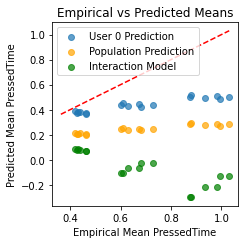

In [56]:
import matplotlib.pyplot as plt

# Filter for user 0
df_user0 = mu_df[mu_df['user_idx'] == 0]

# Scatter plot of empirical vs predicted values
plt.figure(figsize=(3.5, 3.5))
plt.scatter(df_user0['mu_empirical'], df_user0['mu_pred_user'], alpha=0.7, label='User 0 Prediction')
plt.scatter(df_user0['mu_empirical'], df_user0['mu_pred_pop'], alpha=0.7, c='orange', label='Population Prediction')
plt.scatter(df_user0['mu_empirical'], df_user0['mu_interact_model'], alpha=0.7, c='green', label='Interaction Model')

# Diagonal reference line
mn, mx = df_user0[['mu_empirical', 'mu_pred_user']].values.min(), df_user0[['mu_empirical', 'mu_pred_user']].values.max()
plt.plot([mn, mx], [mn, mx], 'r--')

# Axis labels and title
plt.xlabel('Empirical Mean PressedTime')
plt.ylabel('Predicted Mean PressedTime')
plt.title('Empirical vs Predicted Means')
plt.legend()

plt.tight_layout()
plt.savefig('plot.png')
plt.show()


In [45]:
# Compute average MSE per user_idx
avg_mse_per_user = (
    mse_df.groupby("user_idx")[["mse_pred_user", "mse_pred_pop", "mse_interact_model"]]
    .mean()
    .reset_index()
)
avg_mse_per_user

,user_idx,mse_pred_user,mse_pred_pop,mse_interact_model
0,0,0.085899,0.224355,0.673614
1,1,0.110396,0.278180,0.893893
